In [1]:
# Download the corresponding PyTorch Geometric module
%%capture
"""
Assign to TORCH with what you get from the cell above, E.g., export TORCH=1.13.1+cu113
"""
%env TORCH=2.1.0+cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool,global_max_pool
import random
import sys
import os
sys.path.append(os.path.abspath('../utils'))
from Perturbe_Algs import Attacks

In [21]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [23]:
# Load MUTAG, PROTEINS dataset
random.seed(1)
dataset = TUDataset(root='data/TUDataset', name='MUTAG', use_node_attr=True)
dataset = dataset.shuffle()

# Train/test split (80/20)
split_idx = int(0.8 * len(dataset))
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)


In [24]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = torch.relu(x)
        x = F.relu(self.conv2(x, edge_index))
        x = global_max_pool(x, batch)  # Aggregate node features
        x = self.lin(x)
        return x

    def get_ebd(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return x


In [25]:
# Instantiate model
model = GCN(input_dim=dataset.num_node_features,
            hidden_dim=64,
            output_dim=dataset.num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [26]:
# Training loop
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluation
@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

def reset_weights(m):
    if isinstance(m, (torch.nn.Linear, GCNConv)):
        m.reset_parameters()



In [57]:
# Train for a few epochs
model.apply(reset_weights)
num_epochs = 60
train_acc_list = []
test_acc_list = []
for epoch in range(num_epochs):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    if epoch % 20 == 0:
      print(f"Epoch {epoch:02d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 00, Loss: 0.6671, Train Acc: 0.6800, Test Acc: 0.6053
Epoch 20, Loss: 0.5043, Train Acc: 0.7800, Test Acc: 0.7632
Epoch 40, Loss: 0.4786, Train Acc: 0.7933, Test Acc: 0.7632


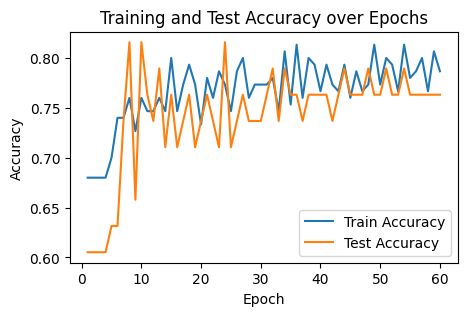

In [71]:
# Plot the training and test accuracy curves
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.show()

In [59]:
from scipy.optimize import root_scalar
from tqdm.notebook import tqdm
import numpy as np
from IPython.display import clear_output
import time
from time import sleep
from copy import deepcopy
from torch_geometric.utils import to_dense_adj

In [60]:
random_dataset = [deepcopy(data) for data in test_dataset]
Prob_PGD_dataset = [deepcopy(data) for data in test_dataset]
Wst_PGD_dataset = [deepcopy(data) for data in test_dataset]

rep_num = 1
list_acc_Prob_PGD = []
list_acc_Wst_PGD = []
list_acc_random = []
embed_Prob_PGD = []
embed_Wst_PGD = []
embed_random = []
list_embed_Prob_PGD = []
list_embed_Wst_PGD = []
list_embed_random = []


lst = [round(x, 2) for x in [0.01 + i * 0.02 for i in range(6)]]
result_col = {}
emb_col = {}

for per in lst:
  result_col[per] = []
  emb_col[per] = []
  for l in range(rep_num):
    for i in (range(len(test_dataset))):
      data = test_dataset[i].to(device)
      edge_index = data.edge_index
      dataA = to_dense_adj(edge_index)[0].clone()
      # Compute the sample second moment (unnormalized)
      K = (data.x) @ (data.x).T
      if dataA.shape[0] == data.x.shape[0]:
        n = dataA.shape[0]
        attack_instance = Attacks(dataA, K, m=int(n*n*per), filter = 'adj_norm_self_loop').to(device)

        A_Prob_PGD = attack_instance.Prob_PGD().clone().detach()
        A_Wst_PGD = attack_instance.Wst_PGD().clone().detach()
        A_random = attack_instance.randomAttack().clone().detach()
      else:
        print('Miss matched data: no operation')
        A_Prob_PGD = dataA.clone().detach()
        A_Wst_PGD = dataA.clone().detach()
        A_random = dataA.clone().detach()

      random_edge_index = torch.tensor(A_random).nonzero(as_tuple=False).t().contiguous()
      Prob_PGD_edge_index = torch.tensor(A_Prob_PGD).nonzero(as_tuple=False).t().contiguous()
      Wst_PGD_edge_index = torch.tensor(A_Wst_PGD).nonzero(as_tuple=False).t().contiguous()

      random_dataset[i].edge_index = random_edge_index
      Prob_PGD_dataset[i].edge_index = Prob_PGD_edge_index
      Wst_PGD_dataset[i].edge_index = Wst_PGD_edge_index

      model.eval()
      with torch.no_grad():
        ebd_test = model.get_ebd(data.x, data.edge_index)
        ebd_pgd_avg = model.get_ebd(data.x, Prob_PGD_edge_index)
        ebd_pgd_wst = model.get_ebd(data.x, Wst_PGD_edge_index)
        ebd_random = model.get_ebd(data.x, random_edge_index)

        embed_Prob_PGD.append(torch.norm(ebd_test - ebd_pgd_avg, p = 'fro'))
        embed_Wst_PGD.append(torch.norm(ebd_test - ebd_pgd_wst, p = 'fro'))
        embed_random.append(torch.norm(ebd_test - ebd_random, p = 'fro'))


    Prob_PGD_test_loader = DataLoader(Prob_PGD_dataset, batch_size=len(Prob_PGD_dataset), shuffle=False)
    Wst_PGD_test_loader = DataLoader(Wst_PGD_dataset, batch_size=len(Wst_PGD_dataset), shuffle=False)
    random_test_loader = DataLoader(random_dataset, batch_size=len(random_dataset), shuffle=False)

    list_embed_Prob_PGD.append(sum(embed_Prob_PGD).item())
    list_embed_Wst_PGD.append(sum(embed_Wst_PGD).item())
    list_embed_random.append(sum(embed_random).item())


    print(f"-----{per*100:.2f}%-----")
    print(f"Test Acc: {test_acc:.4f}")
    prob_PGD_test_acc = test(Prob_PGD_test_loader)
    list_acc_Prob_PGD.append(prob_PGD_test_acc)
    print(f"PGD-AVG Test Acc: {prob_PGD_test_acc:.4f}")

    Wst_PGD_test_acc = test(Wst_PGD_test_loader)
    list_acc_Wst_PGD.append(Wst_PGD_test_acc)
    print(f"PGD-WST Test Acc: {Wst_PGD_test_acc:.4f}")

    random_test_acc = test(random_test_loader)
    list_acc_random.append(random_test_acc)
    print(f"Random Test Acc: {random_test_acc:.4f}")

    emb_col[per].append(sum(embed_random).item())
    emb_col[per].append(sum(embed_Wst_PGD).item())
    emb_col[per].append(sum(embed_Prob_PGD).item())

    result_col[per].append(random_test_acc)
    result_col[per].append(Wst_PGD_test_acc)
    result_col[per].append(prob_PGD_test_acc)



<ipython-input-60-ee7a211ad95a>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  random_edge_index = torch.tensor(A_random).nonzero(as_tuple=False).t().contiguous()
<ipython-input-60-ee7a211ad95a>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Prob_PGD_edge_index = torch.tensor(A_Prob_PGD).nonzero(as_tuple=False).t().contiguous()
<ipython-input-60-ee7a211ad95a>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Wst_PGD_edge_index = torch.tensor(A_Wst_PGD).nonzero(as_tuple=False).t().contiguous()


-----1.0%-----
Test Acc: 0.7632
PGD-AVG Test Acc: 0.7105
PGD-WST Test Acc: 0.7632
Random Test Acc: 0.7632
-----3.0%-----
Test Acc: 0.7632
PGD-AVG Test Acc: 0.5000
PGD-WST Test Acc: 0.7368
Random Test Acc: 0.7895
-----5.0%-----
Test Acc: 0.7632
PGD-AVG Test Acc: 0.4211
PGD-WST Test Acc: 0.7105
Random Test Acc: 0.6842
-----7.000000000000001%-----
Test Acc: 0.7632
PGD-AVG Test Acc: 0.4474
PGD-WST Test Acc: 0.6842
Random Test Acc: 0.6842
-----9.0%-----
Test Acc: 0.7632
PGD-AVG Test Acc: 0.4211
PGD-WST Test Acc: 0.6579
Random Test Acc: 0.7895
-----11.0%-----
Test Acc: 0.7632
PGD-AVG Test Acc: 0.3947
PGD-WST Test Acc: 0.6579
Random Test Acc: 0.7632


In [61]:
random_results = []
pgdavg_results = []
pgdwst_results = []

for per in lst:
  random_results.append(result_col[per][0])
  pgdwst_results.append(result_col[per][1])
  pgdavg_results.append(result_col[per][2])


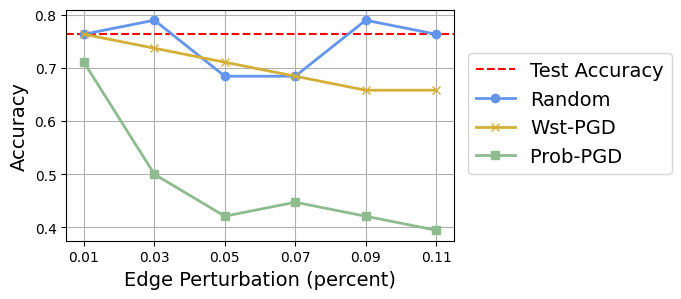

In [66]:

import matplotlib.pyplot as plt
num = 6
plt.figure(figsize=(5, 3))
plt.xticks(lst[0:num])
plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Accuracy')

# plt.axis(lst) # The error was here. 'lst' only contains x-axis values
plt.plot(lst[0:num], random_results[0:num], label='Random', marker='o', color = '#6495ED', alpha=1, linewidth = 2)
plt.plot(lst[0:num], pgdwst_results[0:num], label='Wst-PGD', marker='x', color = '#D4AF37', alpha=1,linewidth = 2)
plt.plot(lst[0:num], pgdavg_results[0:num], label='Prob-PGD ', marker='s', color = '#8FBC8F', alpha=1, linewidth = 2)

plt.xlabel('Edge Perturbation (percent)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(bbox_to_anchor=(1.3, 0.55), loc='center',fontsize = 14)
plt.grid(True)
plt.savefig('mutag_attack_per_acc.pdf',bbox_inches='tight', pad_inches=0.1)

In [63]:
emb_random_results = []
emb_pgdwst_results = []
emb_pgdavg_results = []
for per in lst:
  emb_random_results.append(emb_col[per][0])
  emb_pgdwst_results.append(emb_col[per][1])
  emb_pgdavg_results.append(emb_col[per][2])

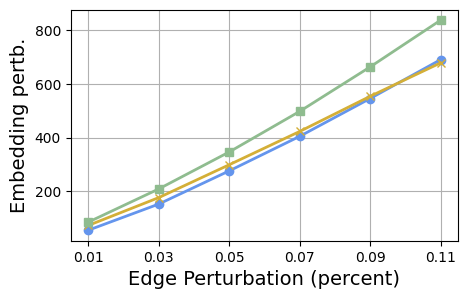

In [72]:

import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.xticks(lst[0:num])
plt.plot(lst[0:num], emb_random_results[0:num], label='Random', marker='o', color='#6495ED', alpha=1, linewidth = 2)
plt.plot(lst[0:num], emb_pgdwst_results[0:num], label='Wst-PGD', marker='x', color = '#D4AF37', alpha=1, linewidth = 2)
plt.plot(lst[0:num], emb_pgdavg_results[0:num], label='Prob-PGD', marker='s', color ='#8FBC8F', alpha=1, linewidth = 2)

plt.xlabel('Edge Perturbation (percent)', fontsize=14)
plt.ylabel('Embedding pertb.',fontsize=14)
plt.grid(True)
# plt.show()
plt.savefig('mutag_attack_per_emb.pdf',bbox_inches='tight', pad_inches=0.1)